In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 2.6 MB/s 
     |████████████████████████████████| 482 kB 5.4 MB/s 
     |████████████████████████████████| 41 kB 494 kB/s 



Graph Dataset

In [ ]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader
 
# Load the MNISTSuperpixel dataset
data = MNISTSuperpixels(root=".")
data

Extracting ./raw/MNISTSuperpixels.zip
Processing...
Done!


MNISTSuperpixels(60000)

# Implementing Graph Neural Network

The GCN simply extends torch.nn.Module. GCNConv expects:

    in_channels = Size of each input sample.
    out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output layer
        self.out = Linear(embedding_size*2, data.num_classes)
    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(1, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=10, bias=True)
)
Number of parameters:  13898


## Training the GNN

In [ ]:
data_size = len(data)
data=data[:int(data_size * 0.15)]

In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Cross EntrophyLoss
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding
print("Starting training...")
losses = []
for epoch in range(500):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 1.5215650796890259
Epoch 10 | Train Loss 1.4856492280960083
Epoch 20 | Train Loss 1.4277688264846802
Epoch 30 | Train Loss 1.4231071472167969
Epoch 40 | Train Loss 1.360479712486267
Epoch 50 | Train Loss 1.3938465118408203
Epoch 60 | Train Loss 1.4424673318862915
Epoch 70 | Train Loss 1.3430346250534058
Epoch 80 | Train Loss 1.3887927532196045
Epoch 90 | Train Loss 1.3358087539672852
Epoch 100 | Train Loss 1.319111704826355
Epoch 110 | Train Loss 1.342343807220459
Epoch 120 | Train Loss 1.2416421175003052
Epoch 130 | Train Loss 1.262344479560852
Epoch 140 | Train Loss 1.3680349588394165
Epoch 150 | Train Loss 1.4285576343536377
Epoch 160 | Train Loss 1.3161044120788574
Epoch 170 | Train Loss 1.3198858499526978
Epoch 180 | Train Loss 1.394052505493164
Epoch 190 | Train Loss 1.3034861087799072
Epoch 200 | Train Loss 1.2781985998153687
Epoch 210 | Train Loss 1.4042556285858154
Epoch 220 | Train Loss 1.3243162631988525
Epoch 230 | Train Loss 1.4354

### Visualizing the Training loss

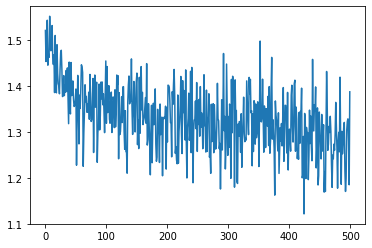

In [ ]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt



### Getting a test prediction

In [ ]:
import pandas as pd 
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    pred=torch.argmax(pred,dim=1)
print(test_batch.y[0])#Actual REsult
print(pred[0])#Predicted Result


tensor(8, device='cuda:0')
tensor(0, device='cuda:0')
